<img src='./assets/images/gun_image_1.jpg'>

# Time Series (WIP)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

#plt.style.use('fivethirtyeight')
#%config InlineBackend.figure_format = 'retina'
#%matplotlib inline

In [2]:
# Styling
# make figures bigger
mpl.rcParams['figure.figsize'] = 12, 8

# change grid line styling
mpl.rcParams['grid.color'] = '#d6dbdf'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=['#6377cb', '#b9bac2'])

In [3]:
gun_df_cleaned = pd.read_csv('./data/gun_violence_cleaned.csv')

In [4]:
gun_df_cleaned.head()

incident_id        date       state city_or_county  n_killed  n_injured  \
0        95289  2014-01-01    Michigan       Muskegon         0          0   
1        92401  2014-01-01  New Jersey         Newark         0          0   
2        92383  2014-01-01    New York         Queens         1          0   
3        92142  2014-01-01    New York       Brooklyn         0          1   
4        95261  2014-01-01    Missouri    Springfield         0          1   

   congressional_district  latitude  longitude  state_house_district  ...  \
0                     2.0   43.2301   -86.2514                  92.0  ...   
1                    10.0   40.7417   -74.1695                  29.0  ...   
2                     5.0   40.7034   -73.7474                  33.0  ...   
3                     9.0   40.6715   -73.9476                  43.0  ...   
4                     7.0   37.2646   -93.3007                 131.0  ...   

   year  month day  day_of_week agegroup_child  agegroup_teen  agegroup_adult  \
0  2014    Jan   1          Wed              0              0               1   
1  2014    Jan   1          Wed              0              0               0   
2  2014    Jan   1          Wed              0              0               2   
3  2014    Jan   1          Wed              0              0               2   
4  2014    Jan   1          Wed              1              1               0   

   agegroup_unknown  num_males  num_females  
0                 0          0            1  
1                 1          0            0  
2                 0          2            0  
3                 0          2            0  
4                 0          0            1  

[5 rows x 21 columns]

In [5]:
gun_df_cleaned.index

RangeIndex(start=0, stop=239399, step=1)

In [37]:
gun_df_cleaned['n_casualties'] = gun_df_cleaned['n_killed'] + gun_df_cleaned['n_injured']
gun_df_cleaned.head()

incident_id        date       state city_or_county  n_killed  n_injured  \
0        95289  2014-01-01    Michigan       Muskegon         0          0   
1        92401  2014-01-01  New Jersey         Newark         0          0   
2        92383  2014-01-01    New York         Queens         1          0   
3        92142  2014-01-01    New York       Brooklyn         0          1   
4        95261  2014-01-01    Missouri    Springfield         0          1   

   congressional_district  latitude  longitude  state_house_district  ...  \
0                     2.0   43.2301   -86.2514                  92.0  ...   
1                    10.0   40.7417   -74.1695                  29.0  ...   
2                     5.0   40.7034   -73.7474                  33.0  ...   
3                     9.0   40.6715   -73.9476                  43.0  ...   
4                     7.0   37.2646   -93.3007                 131.0  ...   

   month  day day_of_week  agegroup_child agegroup_teen  agegroup_adult  \
0    Jan    1         Wed               0             0               1   
1    Jan    1         Wed               0             0               0   
2    Jan    1         Wed               0             0               2   
3    Jan    1         Wed               0             0               2   
4    Jan    1         Wed               1             1               0   

   agegroup_unknown  num_males  num_females  n_casualties  
0                 0          0            1             0  
1                 1          0            0             0  
2                 0          2            0             1  
3                 0          2            0             1  
4                 0          0            1             1  

[5 rows x 22 columns]

In [38]:
# Get number of deaths for each state, indexed by date
by_date_total_df = gun_df_cleaned.groupby('date')['n_casualties'].sum()
# Fill null entries with 0
by_date_total_df = by_date_total_df.fillna(0.0)

In [39]:
by_date_total_df = pd.DataFrame(by_date_total_df)

In [40]:
by_date_total_df.index = pd.to_datetime(by_date_total_df.index)
by_week_total_df = by_date_total_df.resample('W').sum()

In [41]:
by_week_total_df.shape

(222, 1)

In [42]:
by_week_total_df.index

DatetimeIndex(['2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02', '2014-02-09', '2014-02-16', '2014-02-23',
               '2014-03-02', '2014-03-09',
               ...
               '2018-01-28', '2018-02-04', '2018-02-11', '2018-02-18',
               '2018-02-25', '2018-03-04', '2018-03-11', '2018-03-18',
               '2018-03-25', '2018-04-01'],
              dtype='datetime64[ns]', name='date', length=222, freq='W-SUN')

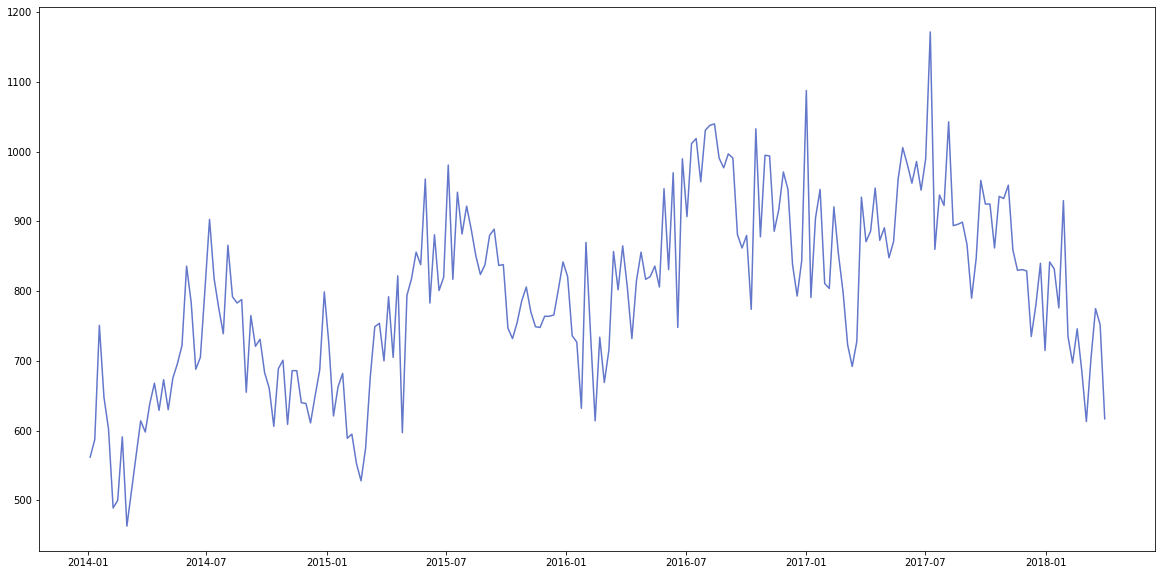

In [43]:
plt.figure(figsize=(20,10))
plt.plot(by_week_total_df);

### Train/Test Split

In [44]:
# Get 80th percentile
by_week_total_df.shape[0] * (0.8)

177.60000000000002

In [45]:
# Set training data to be first 80% of rows
train = by_week_total_df.iloc[0:177]

# Set training data to be last 20% of rows
test = by_week_total_df.iloc[177:]

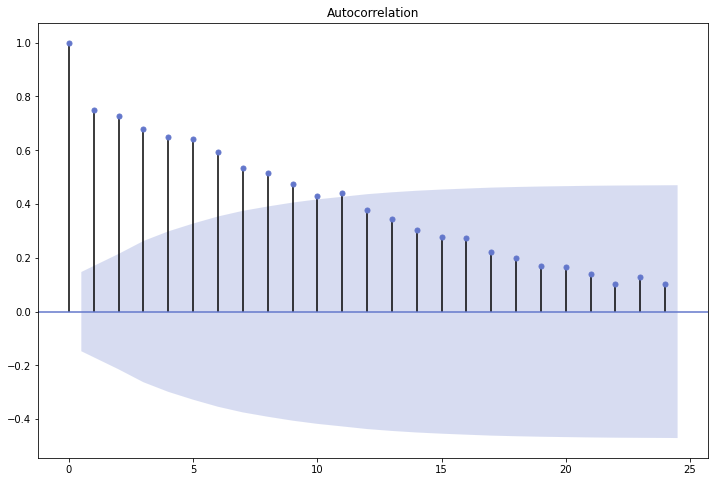

In [47]:
# Generate autocorrelation plot on training data.
plot_acf(train['n_casualties'], lags = 24);

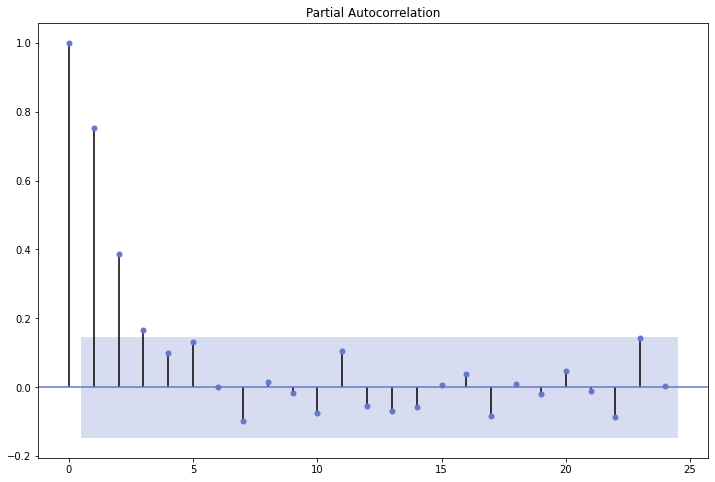

In [48]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['n_casualties'], lags = 24);

In [49]:
train.head()

n_casualties
date                    
2014-01-05           562
2014-01-12           587
2014-01-19           751
2014-01-26           648
2014-02-02           602

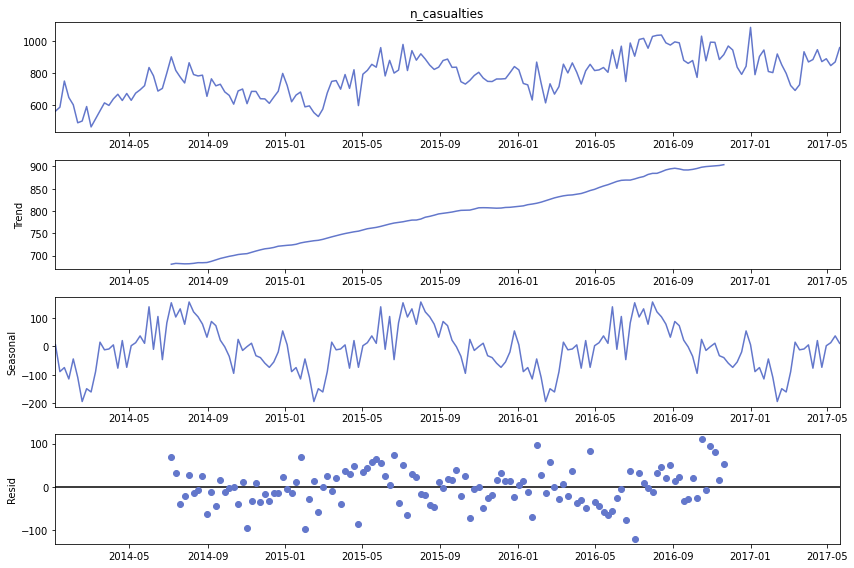

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose

tsindex = train.index
train_ts = train.copy()
train_ts.index = tsindex

result = seasonal_decompose(train_ts.n_casualties)
result.plot();

In [51]:
result.resid[:50]

date
2014-01-05          NaN
2014-01-12          NaN
2014-01-19          NaN
2014-01-26          NaN
2014-02-02          NaN
2014-02-09          NaN
2014-02-16          NaN
2014-02-23          NaN
2014-03-02          NaN
2014-03-09          NaN
2014-03-16          NaN
2014-03-23          NaN
2014-03-30          NaN
2014-04-06          NaN
2014-04-13          NaN
2014-04-20          NaN
2014-04-27          NaN
2014-05-04          NaN
2014-05-11          NaN
2014-05-18          NaN
2014-05-25          NaN
2014-06-01          NaN
2014-06-08          NaN
2014-06-15          NaN
2014-06-22          NaN
2014-06-29          NaN
2014-07-06    68.014824
2014-07-13    31.469952
2014-07-20   -38.863381
2014-07-27   -20.895433
2014-08-03    27.194311
2014-08-10   -12.687099
2014-08-17    -5.856971
2014-08-24    25.094952
2014-08-31   -62.126202
2014-09-07   -10.347356
2014-09-14   -42.937099
2014-09-21    15.380208
2014-09-28   -11.501202
2014-10-05    -2.462740
2014-10-12     0.819311
2014-10-19 

In [52]:
train['n_casualties_diff'] = train['n_casualties'].diff()

/Users/mariannetan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
train.head()

n_casualties  n_casualties_diff
date                                       
2014-01-05           562                NaN
2014-01-12           587               25.0
2014-01-19           751              164.0
2014-01-26           648             -103.0
2014-02-02           602              -46.0

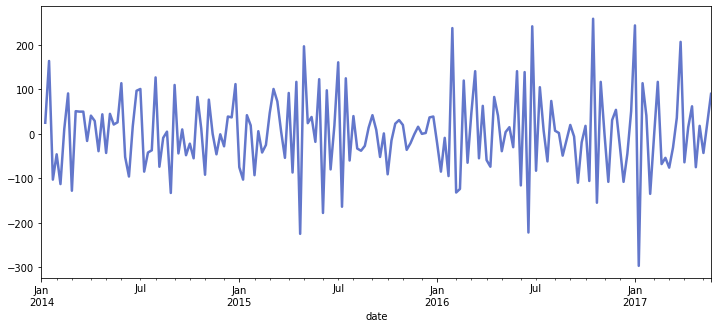

In [54]:
train['n_casualties_diff'].plot(lw=2.5, figsize=(12,5));

In [56]:
from statsmodels.tsa.arima_model import ARMA
udiff = train['n_casualties_diff'][1:]
ar1 = ARMA(udiff.values, (1, 0)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  176
Model:                     ARMA(1, 0)   Log Likelihood               -1017.423
Method:                       css-mle   S.D. of innovations             78.349
Date:                Thu, 06 Aug 2020   AIC                           2040.845
Time:                        17:26:44   BIC                           2050.357
Sample:                             0   HQIC                          2044.703
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0663      4.030      0.513      0.608      -5.833       9.966
ar.L1.y       -0.4680      0.066     -7.040      0.000      -0.598      -0.338
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1369           +0.0000j            2.1369            0.5000
-----------------------------------------------------------------------------
"""

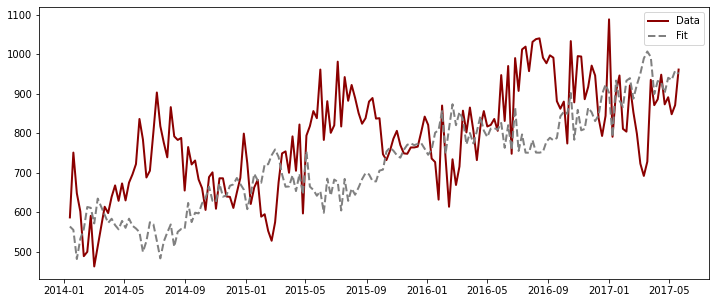

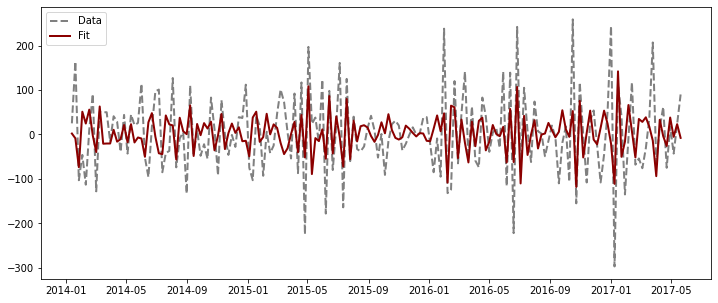

In [57]:
predictions = ar1.predict()
full_pred = train.n_casualties.values[0]+np.cumsum(predictions)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(train.index[1:], train.n_casualties.values[1:], lw=2, color='darkred', label='Data')
ax.plot(train.index[1:], full_pred, lw=2, color='grey', ls='dashed', label='Fit')
plt.legend()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(train.index[1:], udiff, lw=2, color='grey', ls='dashed',label='Data')
ax.plot(train.index[1:], predictions, lw=2, color='darkred',label='Fit')
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import r2_score
r2_score(udiff, ar1.fittedvalues)

0.22008018896622672

In [59]:
ma1 = ARMA(udiff.values, (0, 1)).fit()
ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  176
Model:                     ARMA(0, 1)   Log Likelihood               -1011.196
Method:                       css-mle   S.D. of innovations             75.578
Date:                Thu, 06 Aug 2020   AIC                           2028.392
Time:                        17:26:59   BIC                           2037.903
Sample:                             0   HQIC                          2032.250
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7656      2.237      0.789      0.430      -2.619       6.150
ma.L1.y       -0.6109      0.061     -9.935      0.000      -0.731      -0.490
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.6371           +0.0000j            1.6371            0.0000
-----------------------------------------------------------------------------
"""

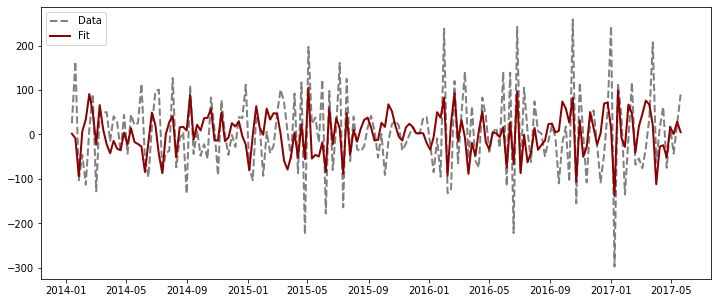

In [60]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(train.index[1:], udiff, lw=2, color='grey', ls='dashed',label='Data')
ax.plot(train.index[1:], ma1.fittedvalues, lw=2, color='darkred',label='Fit')
plt.legend()
plt.show()

In [61]:
from sklearn.metrics import r2_score
r2_score(udiff, ma1.fittedvalues)

0.2721500004407108

/Users/mariannetan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



4894.381472450564


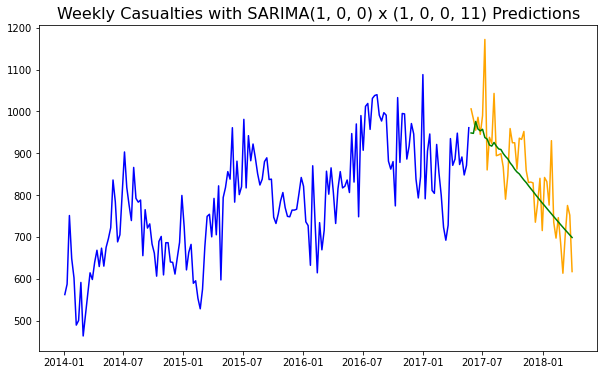

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA(1, 0, 0) x (1, 0, 0, 14) model.

sarima = SARIMAX(endog = train['n_casualties'],
                 order = (1, 0, 0),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 11)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 177 and end at 221.
preds = model.predict(start=177, end=221)

# Evaluate predictions.
print(mean_squared_error(test['n_casualties'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['n_casualties'], color = 'blue')
plt.plot(test['n_casualties'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Weekly Casualties with SARIMA(1, 0, 0) x (1, 0, 0, 11) Predictions', fontsize=16)
plt.show();

In [63]:
preds

2017-05-28    948.455576
2017-06-04    947.475878
2017-06-11    975.914834
2017-06-18    957.890435
2017-06-25    953.489292
2017-07-02    957.217202
2017-07-09    937.484975
2017-07-16    933.777932
2017-07-23    919.657220
2017-07-30    916.925381
2017-08-06    925.753592
2017-08-13    917.034383
2017-08-20    910.357241
2017-08-27    908.786794
2017-09-03    899.295322
2017-09-10    892.197865
2017-09-17    886.550715
2017-09-24    876.930246
2017-10-01    870.114733
2017-10-08    861.564753
2017-10-15    855.022854
2017-10-22    850.517965
2017-10-29    843.052538
2017-11-05    835.989196
2017-11-12    829.853625
2017-11-19    822.408816
2017-11-26    815.425194
2017-12-03    808.740311
2017-12-10    801.422623
2017-12-17    794.635382
2017-12-24    787.598850
2017-12-31    780.955119
2018-01-07    774.708741
2018-01-14    768.001339
2018-01-21    761.409790
2018-01-28    755.023941
2018-02-04    748.459345
2018-02-11    742.019548
2018-02-18    735.676268
2018-02-25    729.269189


In [64]:
def train_prophet(time_series, start=12):
    """Trains the prophet model, making predictions on each value 
    """
    time_series = time_series.reset_index()
    time_series.columns = ['ds', 'y']
    predictions = []
    for i in list(time_series.index)[start:-1]:
        model = Prophet(yearly_seasonality=True)
        model = model.fit(time_series[:i + 2])
        future = model.make_future_dataframe(periods=1)
        output = model.predict(future)
        predictions.append(output.tail(1)[['ds', 'yhat', 'yhat_upper', 'yhat_lower']])

    predictions = pd.concat(predictions).set_index('ds')
    
    return predictions

def plot_predictions(truth, predictions):
    """Plots the truth alongside the predictions and visualize how good the time forecasting model is.
    """
    truth.plot(color='g', label='truth')
    predictions['yhat'].plot(label='predictions')
    predictions['yhat_upper'].plot(color='r', alpha=0.3, ls='--')
    predictions['yhat_lower'].plot(color='r', alpha=0.3, ls='--')
    plt.legend()
    plt.show()

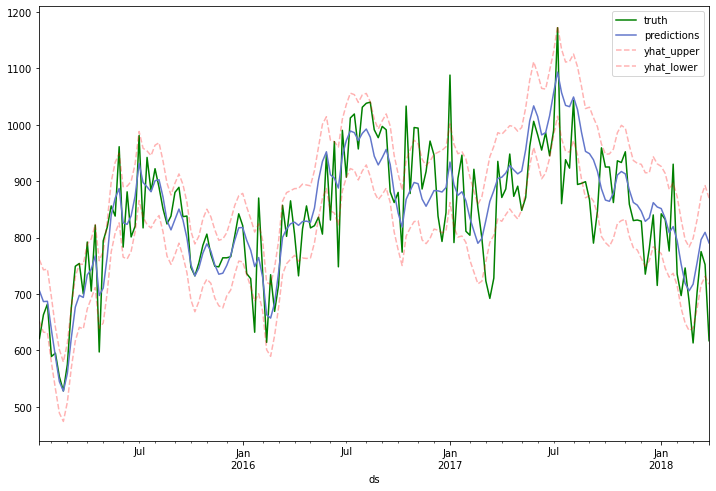

MSE: 4161.994993426307
Aggregated Weekly: 4161.994993426307


In [65]:
# Get weekly time series
start=52

time_series = by_date_total_df.resample('W').sum().sum(axis=1)
time_series.index = pd.to_datetime(time_series.index)
truth = time_series[start + 1:]

# Make predictions and plot
predictions = train_prophet(time_series, start=start)
plot_predictions(truth, predictions)

# Calculate MSE
print("MSE: {}".format(mean_squared_error(truth, predictions['yhat'])))
print("Aggregated Weekly: {}".format(
    mean_squared_error(truth.resample('W').sum(), predictions['yhat'].resample('W').sum())))

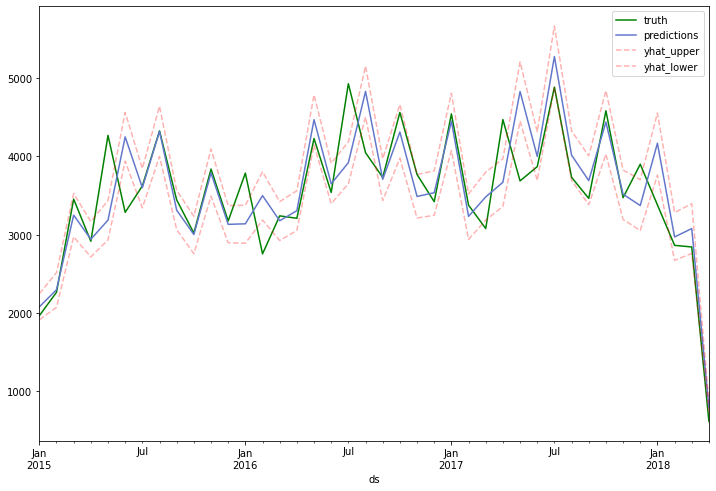

MSE: 4161.994993426307
Aggregated Monthly: 211543.9237669254


In [66]:
resampled_truth = truth.resample('M').sum()
resampled_preds = predictions.resample('M').sum()

plot_predictions(resampled_truth, resampled_preds)

# Calculate MSE
print("MSE: {}".format(mean_squared_error(truth, predictions['yhat'])))
print("Aggregated Monthly: {}".format(
    mean_squared_error(truth.resample('M').sum(), predictions['yhat'].resample('M').sum())))

In [67]:
truth.resample('M').sum()

date
2015-01-31    1966
2015-02-28    2265
2015-03-31    3454
2015-04-30    2916
2015-05-31    4267
2015-06-30    3285
2015-07-31    3622
2015-08-31    4324
2015-09-30    3444
2015-10-31    3020
2015-11-30    3837
2015-12-31    3175
2016-01-31    3786
2016-02-29    2755
2016-03-31    3240
2016-04-30    3209
2016-05-31    4227
2016-06-30    3539
2016-07-31    4926
2016-08-31    4046
2016-09-30    3731
2016-10-31    4560
2016-11-30    3768
2016-12-31    3421
2017-01-31    4541
2017-02-28    3377
2017-03-31    3078
2017-04-30    4469
2017-05-31    3686
2017-06-30    3868
2017-07-31    4883
2017-08-31    3732
2017-09-30    3463
2017-10-31    4581
2017-11-30    3472
2017-12-31    3899
2018-01-31    3380
2018-02-28    2864
2018-03-31    2843
2018-04-30     617
Freq: M, dtype: int64

In [68]:
truth

date
2015-01-11    621
2015-01-18    663
2015-01-25    682
2015-02-01    589
2015-02-08    595
             ... 
2018-03-04    613
2018-03-11    703
2018-03-18    775
2018-03-25    752
2018-04-01    617
Freq: W-SUN, Length: 169, dtype: int64

In [69]:
df = by_week_total_df.reset_index()

In [70]:
df.rename(columns = {'date':'ds',
                    'n_casualties':'y'}, inplace=True)

In [71]:
m = Prophet(interval_width=0.95,holidays_prior_scale=3)
m.add_country_holidays(country_name='US')
m.fit(df)

In [72]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
582 2019-03-28
583 2019-03-29
584 2019-03-30
585 2019-03-31
586 2019-04-01

In [73]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
582 2019-03-28  729.327013  614.632775  845.888626
583 2019-03-29  730.073646  595.461732  845.079998
584 2019-03-30  730.880099  604.685690  849.412630
585 2019-03-31  731.794817  600.487135  861.267508
586 2019-04-01  732.858191  623.879868  849.425620

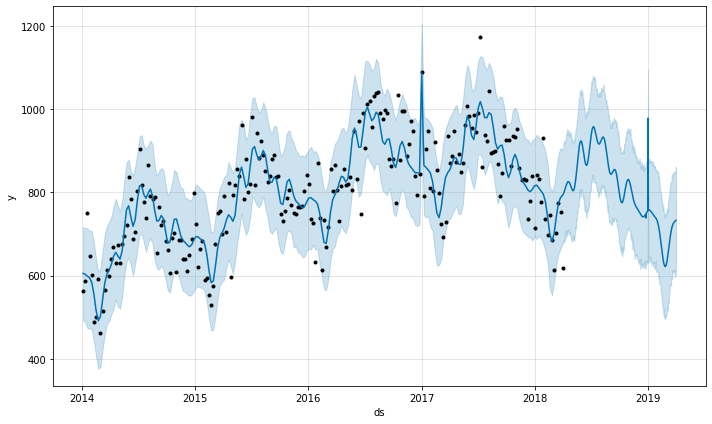

In [74]:
fig1 = m.plot(forecast)

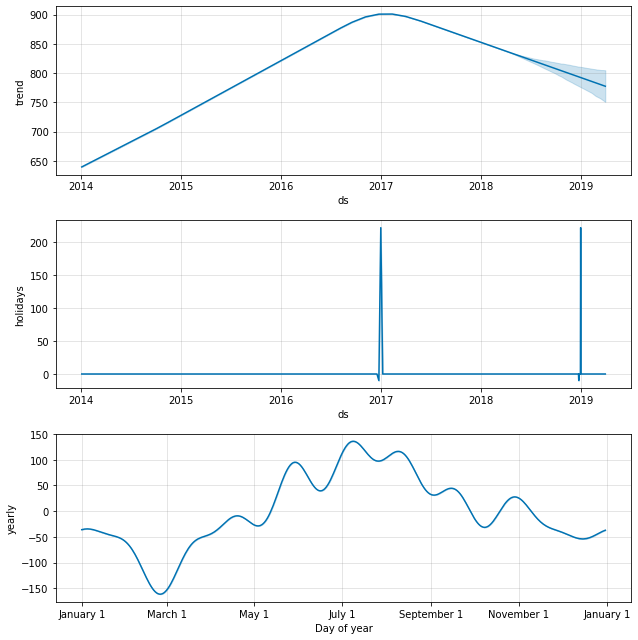

In [75]:
fig2 = m.plot_components(forecast)

In [76]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)